# ZI simulations

After the data cleaning process I carried on simulations utilizing the ZI model.

For each trading day I:

1. Computed the parameters $\lambda$, $\mu$, $\delta$, (arrival rates of LO, MO, cancellations) from the empirical data.
2. Simulated the LOB using the ZI model.
3. Compared empirical and simulated mean spread and volatility.



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
sys.path.append("../main/")
import ZI


In [2]:
# Load cleaned data
df = ZI.load_LOB_data("../data/energia/order/new_best.csv")
days = pd.unique(df["Datetime"].dt.day)

In [3]:
real_sp = np.zeros(days.shape[0])
zi_sp = np.zeros(days.shape[0])
real_vol = np.zeros(days.shape[0])
zi_vol = np.zeros(days.shape[0])

# Repeat for each trading day
for i, day in enumerate(days):
    print(f"Simulating ZI for day {day}/10...")
    new_df = df[df["Datetime"].dt.day == day]
    # Compute rate arrival of LO, MO and cancellations
    rate_l, rate_m, rate_c = ZI.find_parameters(new_df)
    # Compute empirical mean spread and volatility 
    real_vol[i] = ((new_df["MidPrice"].diff(100)**2).mean() / 100)**.5
    real_sp[i] = new_df["Spread"].mean()
    lenght = int(real_sp[i] * 10)
    # Simulate LOB using the ZI model
    message, order = ZI.sim_LOB(rate_l, rate_m, rate_c, m0 = 100_00,
                                k = lenght, iterations = 20_000, burn = 5_000)
    # Compute simulations mean spread and volatility 
    zi_sp[i] = message["Spread"].mean()
    zi_vol[i] = ((message["MidPrice"].diff(100)**2).mean() / 100)**.5

Simulating ZI for day 1/10...
Simulating ZI for day 4/10...
Simulating ZI for day 5/10...
Simulating ZI for day 6/10...
Simulating ZI for day 7/10...
Simulating ZI for day 8/10...
Simulating ZI for day 11/10...
Simulating ZI for day 12/10...
Simulating ZI for day 13/10...
Simulating ZI for day 14/10...
Simulating ZI for day 15/10...
Simulating ZI for day 18/10...
Simulating ZI for day 19/10...
Simulating ZI for day 20/10...
Simulating ZI for day 21/10...
Simulating ZI for day 22/10...
Simulating ZI for day 25/10...
Simulating ZI for day 26/10...
Simulating ZI for day 28/10...
Simulating ZI for day 29/10...


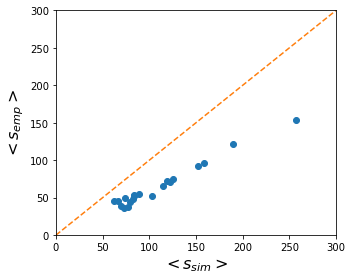

In [4]:
# Plot empirical vs simulated mean spread
fig, ax = plt.subplots(1, 1, figsize = (5,4), tight_layout = True)
plt.plot(zi_sp, real_sp, ls="", marker = "o")
plt.xlabel(r"$<s_{sim}>$", fontsize = 16)
plt.ylabel(r"$<s_{emp}>$", fontsize = 16)
#plt.title("Empirical vs simulated mean spread ZI", fontsize = 22)
xx = np.linspace(0,300,20)
plt.xlim(0,300)
plt.ylim(0,300)
plt.plot(xx, xx, ls="--")
plt.show()

(0.0, 27.0)

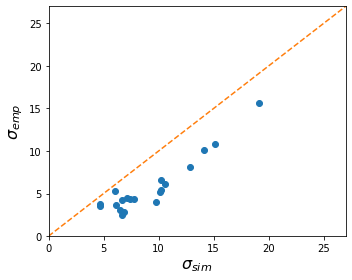

In [5]:
# Plot empirical vs simulated volatility
fig, ax = plt.subplots(1, 1, figsize = (5,4), tight_layout = True)
plt.plot(zi_vol, real_vol,  ls="", marker = "o")
xx = np.linspace(0,27,20)
plt.plot(xx, xx, ls="--")
plt.xlabel(r"$\sigma_{sim}$", fontsize = 16)
plt.ylabel(r"$\sigma_{emp}$", fontsize = 16)
plt.xlim(0,27)
plt.ylim(0,27)
#plt.title("Empirical vs simulated volatility ZI", fontsize = 22)

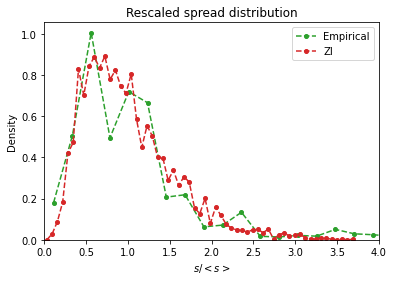

In [6]:
# plot rescaled spread distribution
emp_sp = new_df["Spread"]
zi_sp = message["Spread"]
n, bins, _ = plt.hist(emp_sp, density = True, bins = np.arange(0,200,10), alpha = 0)
n1, bins1, _ = plt.hist(zi_sp, density = True, bins = np.arange(0,300,5), alpha = 0)

#rescale
x = (bins[:-1] + bins[1:]) / emp_sp.mean() / 2
x1 = (bins1[:-1] + bins1[1:]) / zi_sp.mean() / 2
n  = n * emp_sp.mean()
n1 = n1 * zi_sp.mean()

plt.plot(x,n, "o", ls = "--", label = "Empirical", markersize = 4)
plt.plot(x1,n1, "o", ls = "--", label = "ZI", markersize = 4)
plt.legend()
plt.xlim(0,4)
plt.xlabel(r"$s / <s> $")
plt.ylabel("Density")
plt.title("Rescaled spread distribution")
plt.show()

In [23]:
new_df = df[df["Datetime"].dt.day == day]
# Compute rate arrival of LO, MO and cancellations
rate_l, rate_m, rate_c = ZI.find_parameters(new_df)
# Compute empirical mean spread and volatility 
real_vol[i] = ((new_df["MidPrice"].diff(100)**2).mean() / 100)**.5
real_sp[i] = new_df["Spread"].mean()
lenght = int(real_sp[i] * 10)
# Simulate LOB using the ZI model
message, order = ZI.sim_LOB(rate_l, rate_m, rate_c, m0 = 100_00,
                            k = lenght, iterations = 15_000_000, burn = 20_000)
# Compute simulations mean spread and volatility 
zi_sp[i] = message["Spread"].mean()
zi_vol[i] = ((message["MidPrice"].diff(100)**2).mean() / 100)**.5

In [24]:
def compute_price_impact(price,sign,max_lag,step=1):
    impact = []
    std_impact = []
    for i in range(1,max_lag + 1,step):
        impact.append((sign[:-i:i]*(price[i::i]-price[:-i:i])).mean())
        std_impact.append((sign[:-i:i]*(price[i::i]-price[:-i:i])).std() / np.sqrt(len(price[i::i])))
    
    return impact, std_impact

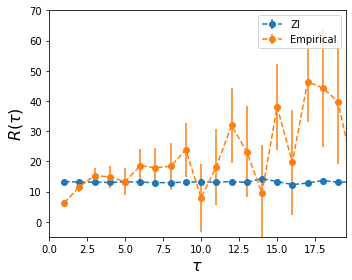

In [72]:
idx_sell = message[message["Type"] == "Market"].index.to_numpy()
sign = message.loc[idx_sell]["Sign"].to_numpy()
mid_p = message.loc[idx_sell - 1]["MidPrice"].to_numpy()
fig, ax = plt.subplots(1, 1, figsize = (5,4), tight_layout = True)
imp, err = compute_price_impact(mid_p,sign,30,step=1)
plt.errorbar(np.arange(1,31), imp, err, ls = "--", marker = "o", label = "ZI")

new_df = df[df["Datetime"].dt.day == 29]
idx_sell = new_df[new_df["Type"] == "Market"].index.to_numpy()
sign = new_df.loc[idx_sell]["Sign"].to_numpy()
mid_p = new_df.loc[idx_sell - 1]["MidPrice"].to_numpy()
imp, err = compute_price_impact(mid_p,sign,30,step=1)
plt.errorbar(np.arange(1,31), imp, err, ls = "--", marker = "o", label = "Empirical")
plt.xlim(0,19.5)
plt.ylim(-5,70)
plt.xlabel(r"$\tau$", fontsize = 16)
plt.ylabel(r"$R(\tau)$", fontsize = 16)
plt.legend()
plt.savefig("C://Users//spina//Documents//SOLDI//tesi fig//Chapter5//M_IMPACT1.png", dpi = 300)

In [44]:
pp = compute_price_impact(mid_p,sign,50,step=1)[0]

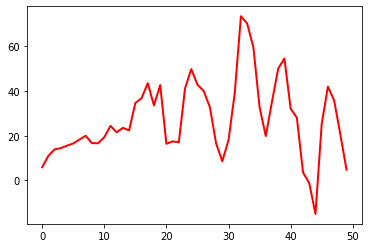

In [45]:
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth
x = np.arange(50)
#plt.plot(x, pp,'o')
plt.plot(x, smooth(pp,3), 'r-', lw=2)
#plt.plot(x, smooth(pp,5), 'g-', lw=2)


In [28]:
 smooth(pp,3)

array([ 8.80918752, 13.16967   , 13.07572823, 13.10737376, 13.10809729,
       13.0882899 , 12.98982911, 12.99778227, 13.0964283 , 13.12907831,
       13.19838595, 13.12553764, 13.52984201, 13.53115089, 13.28680418,
       12.80236218, 12.90681218, 13.16660297, 13.30426188, 13.06537878,
       12.80795906, 12.75364372, 12.88149144, 13.57393081, 13.22235522,
       13.40907891, 13.13921877, 13.90874744, 13.52140503, 13.17978954,
       12.09620689, 12.05805082, 11.95728601, 12.70239566, 12.77582955,
       13.15724425, 13.11147078, 13.28036694, 13.29814305, 13.24970783,
       14.20755849, 14.61588681, 13.60541538, 12.48061158, 11.7922224 ,
       12.78980737, 12.95219917, 13.14668281, 13.88895727,  9.45677303])